# Example of how to find peaks in a synthetic image
 - Create a set of 2D Gaussians
 - Find the center of the Guassian to integer accuracy
 - Optimize the position using Gaussian fitting for each peak

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

# Import these from ncempy.algo
from ncempy.algo import gaussND
from ncempy.algo import peak_find

# Create a sample 2D Image
 - Gaussians are placed on a grid with some random small offsets
 - the variable coords are the known positions 
  - these will not be known in a real experiment

Coords shape = (25, 2)


<IPython.core.display.Javascript object>


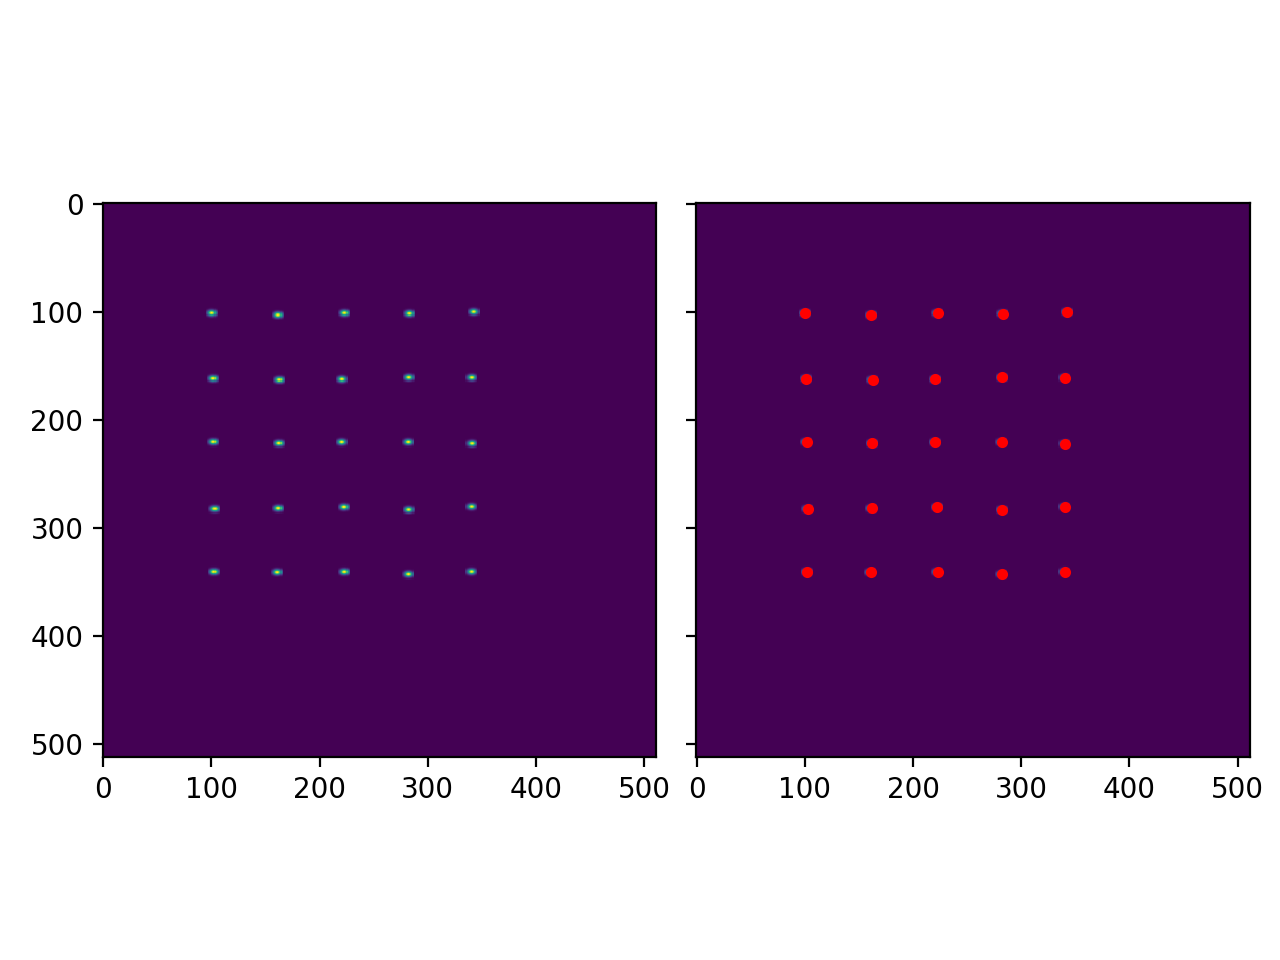

In [36]:
# Create coordinates with a random offset
coords = peak_find.lattice2D_2((1, 0), (0, 1), 2, 2, (0, 0), (5, 5))
coords += np.random.rand(coords.shape[0], coords.shape[1]) / 10.0
coords = np.array(coords)*30 + (100, 100)
print('Coords shape = {}'.format(coords.shape))

# Create an image with the coordinates as gaussians
kernel_shape = (11, 11)
simIm = peak_find.peaksToImage(coords, (512, 512), (1.75, 2.75), kernel_shape)
    
fg, ax = plt.subplots(1, 2, sharex=True,sharey=True)
ax[0].imshow(simIm)
ax[1].imshow(simIm)
ax[1].scatter(coords[:,1], coords[:,0],c='r',marker='.')
fg.tight_layout()

# Find the center pixel of each peak
 - uses ncempy.algo.peakFind.peakFind2D()
 - These will be integer values of the max peak positions.
 - Gaussian fitting will be used to find the smal random offsets
 - See end of notebook for an explanation as to how this works.

<IPython.core.display.Javascript object>


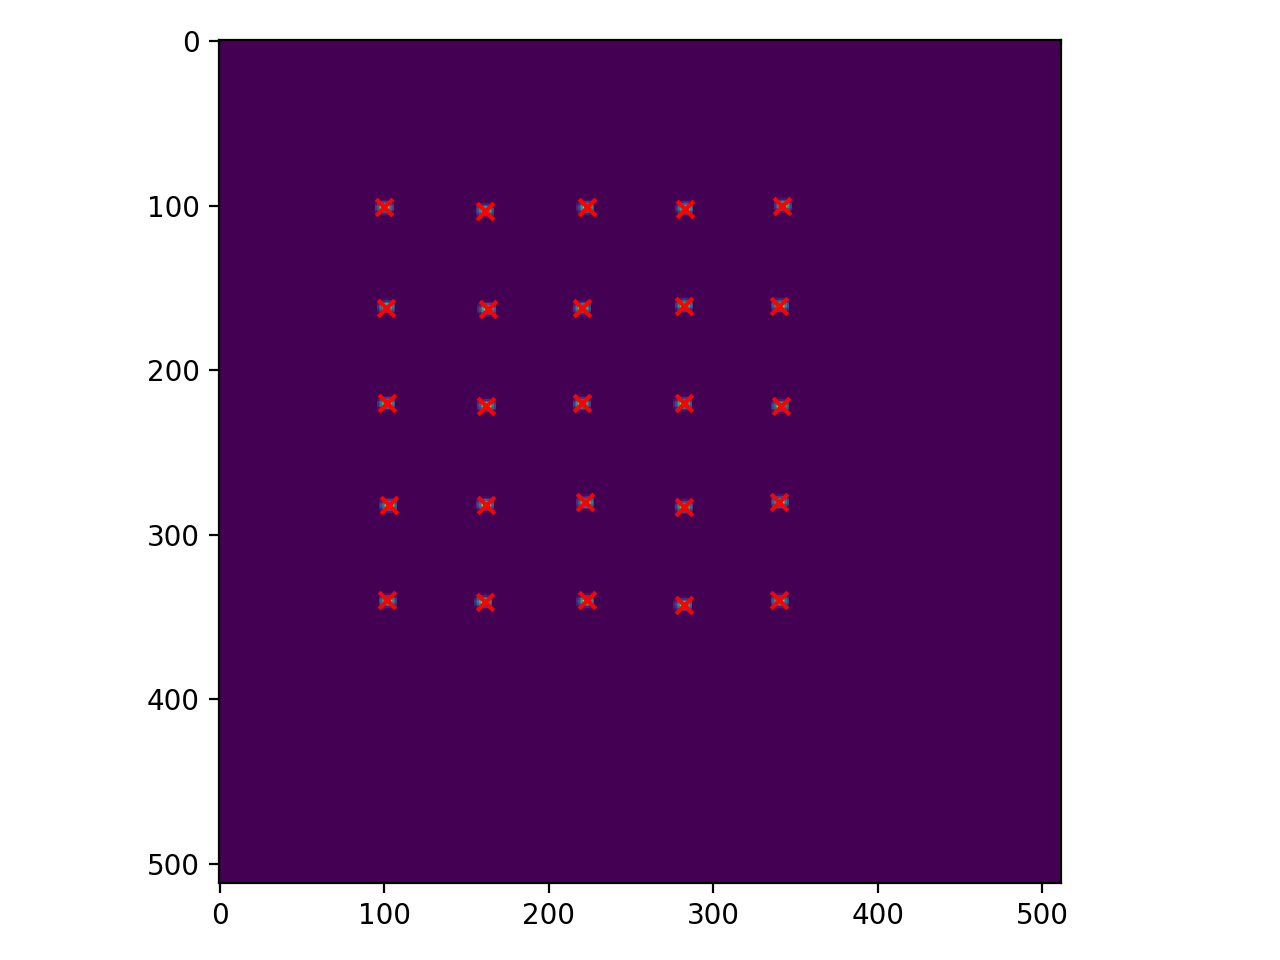

In [37]:
coords_found = peak_find.peakFind2D(simIm, 0.5)

fg, ax = plt.subplots(1,1)
ax.imshow(simIm)
_ = ax.scatter(coords_found[:,1],coords_found[:,0],c='r',marker='x')

# Use Gaussian fitting for sub-pixel fitting
 - Each peak is fit to a 2D Gaussian function
 - The average of the sigma values is printed

<IPython.core.display.Javascript object>


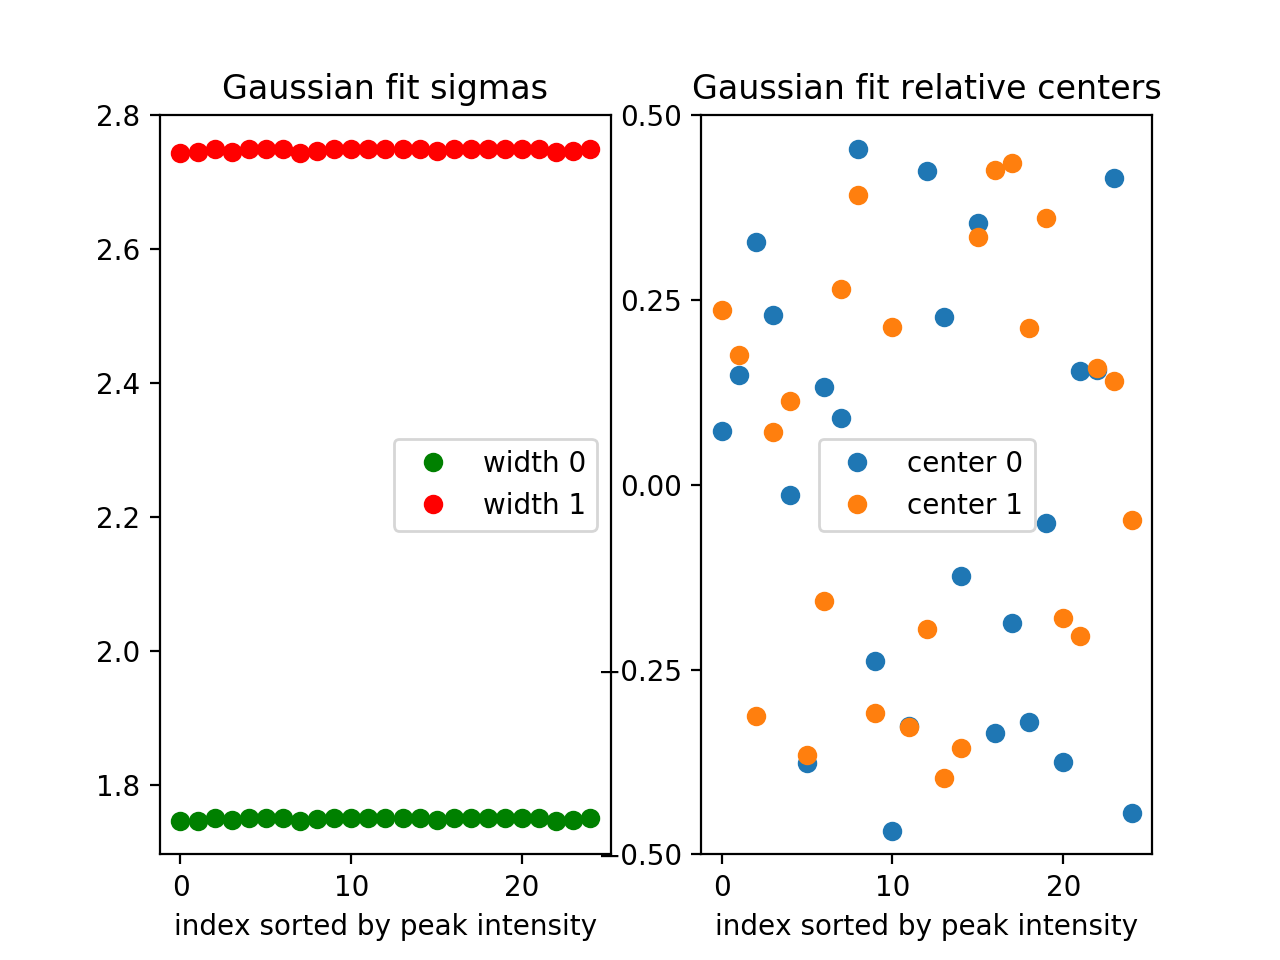

Sigma means [s_0, s_1]: [1.74895773 2.74850314]


In [38]:
optPeaks, optI, fittingValues = peak_find.fit_peaks_gauss2d(simIm, coords_found, 5, 
                                                           (1.5, 2.5), ((-1.5, -1.5,0,0),(1.5,1.5,3,3)))

# Plot the gaussian widths
f2, ax2 = plt.subplots(1, 2)
ax2[0].plot(optPeaks[:, 2],'go')
ax2[0].plot(optPeaks[:, 3],'ro')
ax2[0].set(title='Gaussian fit sigmas',xlabel='index sorted by peak intensity')
ax2[0].legend(labels=['width 0', 'width 1'])
stdMeans = np.mean(optPeaks[:, 2:4], axis=0)

# Print out the average of the fitted sigmas
print('Sigma means [s_0, s_1]: {}'.format(stdMeans))

# Plot the fitted center (relative from the intensity peak)
ax2[1].plot(fittingValues[:, 0], 'o')
ax2[1].plot(fittingValues[:, 1], 'o')
ax2[1].set(title="Gaussian fit relative centers", xlabel='index sorted by peak intensity')
_ = ax2[1].legend(labels=['center 0', 'center 1'])
ax2[1].set(ylim=(-0.5, 0.5))
ax2[1].set(yticks=(-0.5, -0.25, 0, 0.25, 0.5))
fg.tight_layout()

# Plot to compare the known and fitted coordinates
 - coords are the expected positions we used to generate the image
 - coords_found are the peaks found with full pixel precision
 - optPeaks are the optimized peak positions using Gaussian fitting

<IPython.core.display.Javascript object>


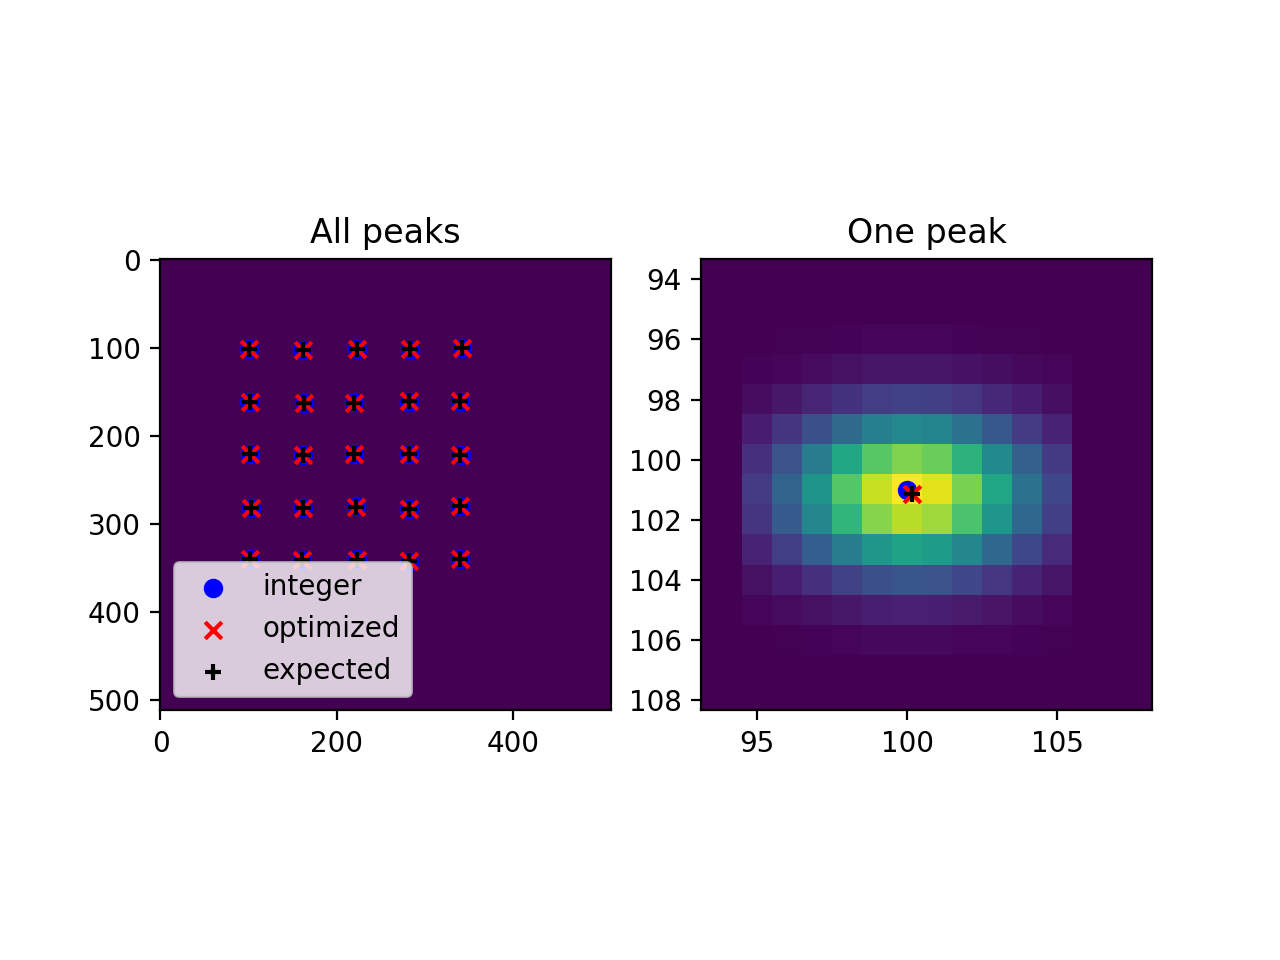

In [39]:
fg, ax = plt.subplots(1, 2)
ax[0].imshow(simIm)
ax[0].scatter(coords_found[:,1], coords_found[:,0],c='b',marker='o')
ax[0].scatter(optPeaks[:,1], optPeaks[:,0],c='r',marker='x')
ax[0].scatter(coords[:,1], coords[:,0],c='k',marker='+')
ax[0].legend(['integer', 'optimized', 'expected'])
ax[0].set(title='All peaks')

# Zoom in on one peak
ax[1].imshow(simIm)
ax[1].scatter(coords_found[:,1], coords_found[:,0],c='b',marker='o')
ax[1].scatter(optPeaks[:,1], optPeaks[:,0],c='r',marker='x')
ax[1].scatter(coords[:,1], coords[:,0],c='k',marker='+')
ax[1].axis((100,115,110,95))
ax[0].legend(['integer', 'optimized', 'expected'])
ax[1].set(title='One peak');

# Find the error in the fitting
 - Gausssian fitting can be heavily influenced by the tails
 - Some error is expected.

<IPython.core.display.Javascript object>


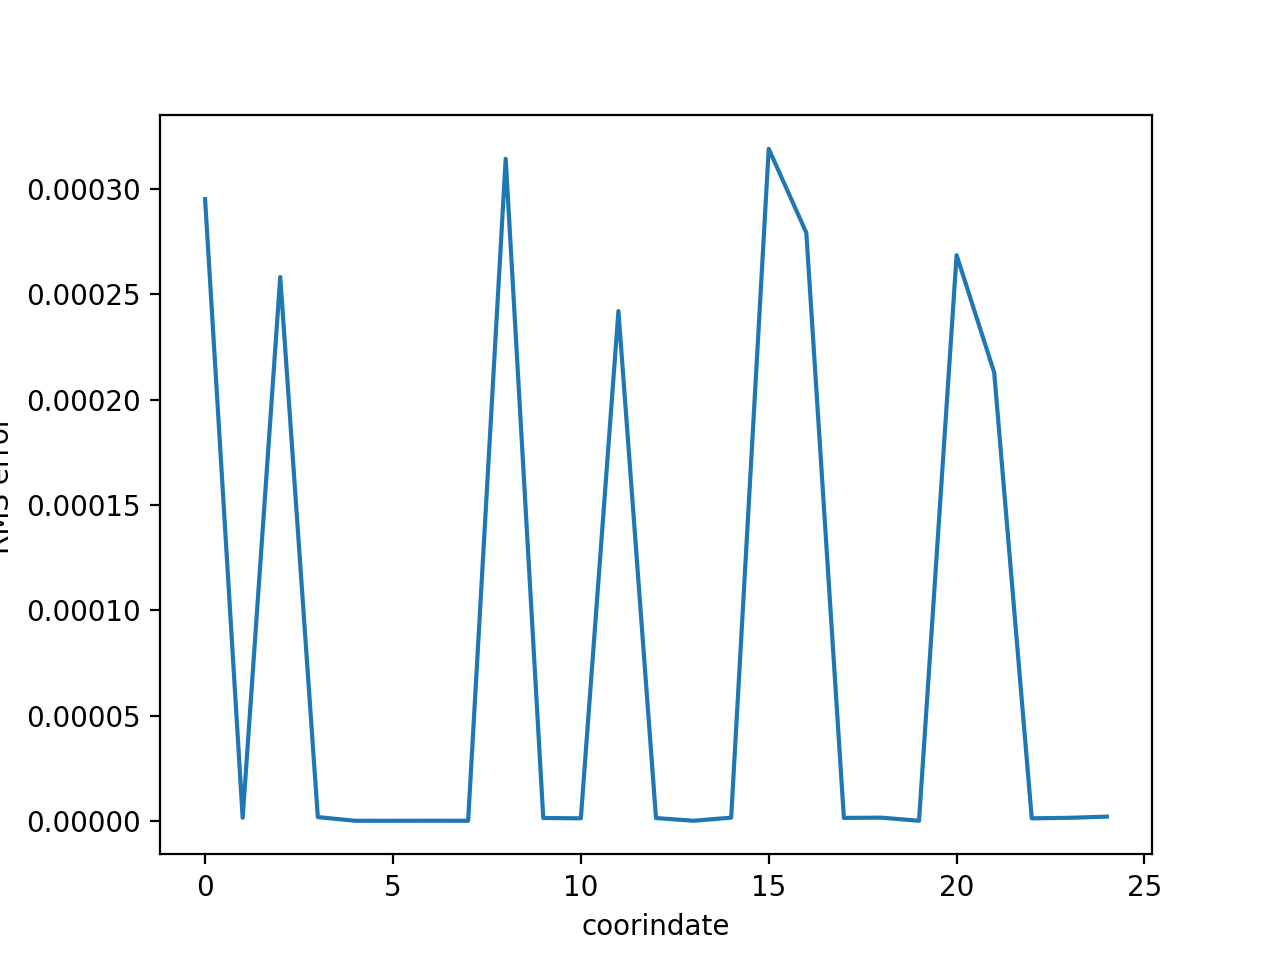

In [40]:
# Plot the RMS error for each fitted peak
# First sort each set of coordinates to match them
err = []
for a, b in zip(coords[np.argsort(coords[:,0]),:], optPeaks[np.argsort(optPeaks[:,0]),0:2]):
    err.append(np.sqrt(np.sum(a - b)**2))
    
fg, ax = plt.subplots(1, 1)
ax.plot(err)
_ = ax.set(xlabel='coorindate', ylabel='RMS error');

# Fit a lattice to the peaks

origin: [101.77978091 101.89326962]
u: [ 9.99999885e-01 -4.78631839e-04]
v: [-0.00214672  0.9999977 ]
|u|: 59.85716647675226, |v|: 59.87581384510741 (pixels)
angles: UV: 90.1504213913277


<IPython.core.display.Javascript object>


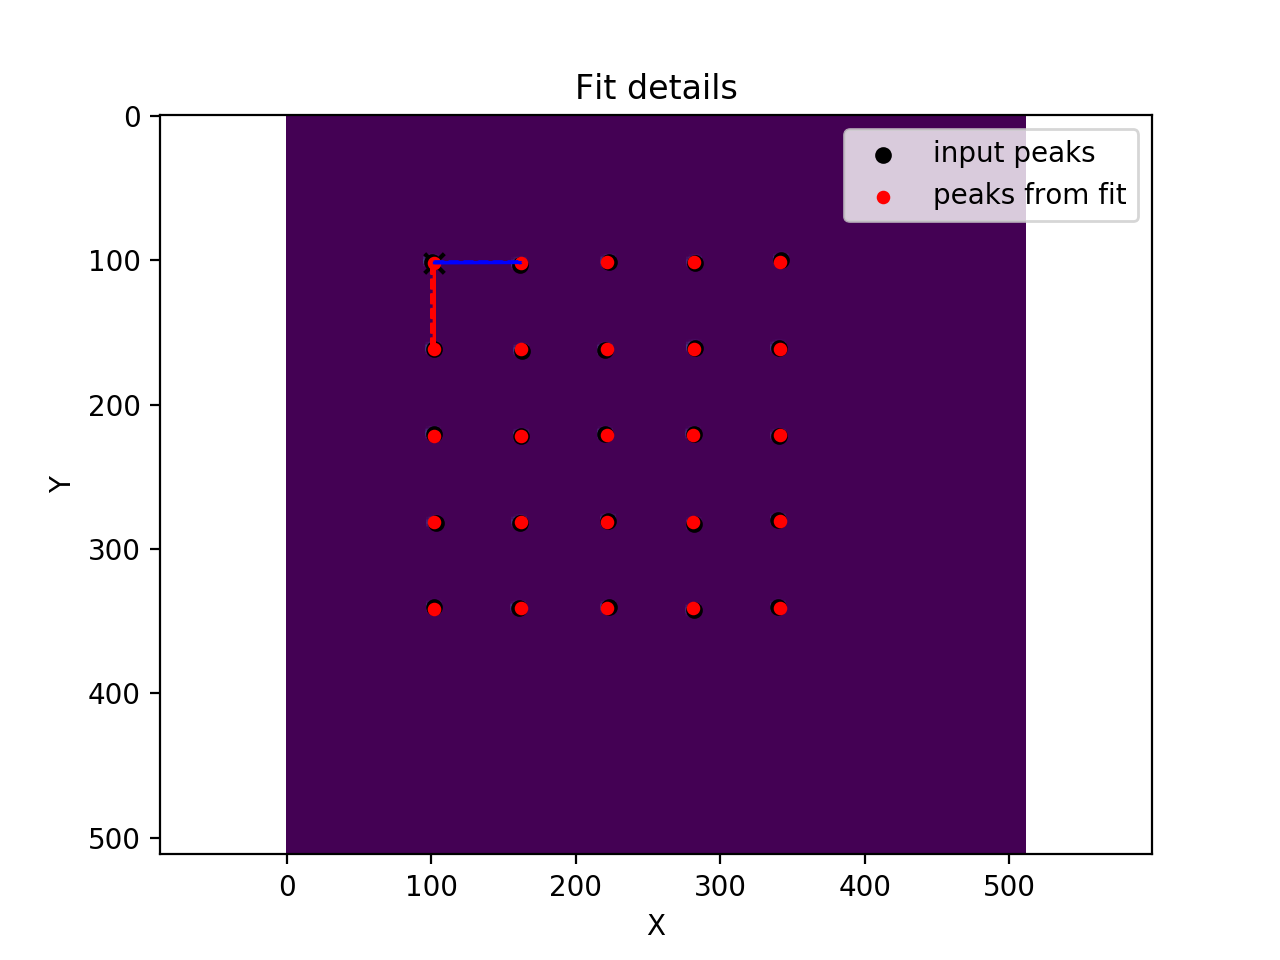

In [46]:
# Find a lattice from the found Pb peak sites
p0 = optPeaks[:, 0:2].copy()

# Find the top left atom
corner = (0,0)
modelRR = np.sqrt(np.sum((p0 - corner)**2, axis=1)) #Distances from middle of particle
centerAtom = modelRR.argmin() #Minimum distance from NP middle

# Input starting guess at vectors
origin0 = p0[centerAtom,:].copy()
u0 = [60, 0] # verical in imshow()
v0 = [0, 60] # horizontal in imshow()
fraction = (1,1)

origin,u,v,ab = peak_find.refineLattice2D(origin0, u0, v0, p0,
                                          refine_locally=True,
                                          fraction=fraction)

# Normalize the vectors
uN = u/np.linalg.norm(u)
vN = v/np.linalg.norm(v)

# Find the angles between vectors
angleUV = np.arccos(np.dot(uN, vN))*180./np.pi

# Print out the results
print('origin: {}'.format(origin))
print('u: {}\nv: {}'.format(uN, vN))
print('|u|: {0[0]}, |v|: {0[1]} (pixels)'.format(np.linalg.norm([u, v],axis=1)))
print('angles: UV: {}'.format(angleUV))

# Plot all positions and the vectors
f124, ax124 = plt.subplots(1,1,clear=True)
ax124.imshow(simIm)
ax124.scatter(origin[1],origin[0],c='k',s=50,marker='x') #add 0,0,0 as a black X
ax124.scatter(p0[:,1], p0[:,0], s=25, label='input peaks',c='k')
#Plot original vectors guesses
ax124.arrow(origin0[1],origin0[0],u0[1],u0[0],color='r',ls='--')
ax124.arrow(origin0[1],origin0[0],v0[1],v0[0],color='b',ls='--')

#Plot a perfect verion of the {u,v,w} lattice
uvLattice = peak_find.lattice2D(u,v,1,1,origin,[5, 5])
ax124.scatter(uvLattice[:,1],uvLattice[:,0],s=15,color='r',label='peaks from fit')
#Plot optimized vectors
ax124.arrow(origin[1],origin[0],u[1],u[0],color='r')
ax124.arrow(origin[1],origin[0],v[1],v[0],color='b')
# Clean up the plot
ax124.set(xlabel='X',ylabel='Y',title='Fit details');
ax124.legend()
ax124.axis('equal');

# Unit cell calculation

In [ ]:
peak_find.calculate_unit_cell